In [41]:
# Khai báo các thư viện cần thiết
import torch
import numpy as np
import random
import os
import pickle
from collections import deque
import torch.nn as nn
import torch.nn.functional as F

In [42]:
# Khai báo các hằng số sử dụng
class Action:
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
class Maze:
    WALL = -1
    UNEXPLORED = 0
    PATH = 1
    GOAL = 2
    AGENT_POSITION = 3
class Buff:
    NONE = 0
    SENRIGAN = 1
    TOU_NO_HIKARI = 2
    SLIME_SAN_ONEGAI = 3
    UNMEI_NO_MICHI = 4
    SLIME_STEP = 150
    TOU_NO_HIKARI_OBS = 10
    UNMEI_NO_MICHI_PATH = 1
class Debuff:
    NONE = 0
    WAAMU_HOURU = 1
    SHIN_NO_MEIRO = 2

In [ ]:
# Môi trường Mê cung

class MazeEnv():
    # Môi trường mê cung
    # Maze: Mê cung được tạo ra ngẫu nhiên với các ô đường và tường
    # Với các ô đường được đánh dấu là 0 và các ô tường được đánh dấu là -1, ô đích được đánh dấu là 2
    # Discovered_maze: Mê cung đã được khám phá trong quá trình di chuyển của tác tử
    # Với các ô đường được đánh dấu là 0, các ô tường được đánh dấu là -5, đích được đánh dấu là 10, ô chưa được khám phá được đánh dấu là 1
    # Giá trị các ô đường giảm dần mỗi lần tác tử đi qua
    # Agent_position: Vị trí hiện tại của tác tử trong mê cung
    # Base_position: Vị trí ban đầu của tác tử trong mê cung
    # Goal_position: Vị trí đích trong mê cung
    # Buff: Biến để xác định xem tác tử có đang sử dụng buff senrigan hay không
    # Debuff: Biến để xác định xem tác tử có đang bị debuff shin no meiro hay không

    def __init__(self, maze_size, max_steps = 15, path_percent = 70):
        """
        Khởi tạo môi trường Mê cung.

        Args:
        - maze_size (int): Kích thước của mê cung (ví dụ: 50x50).
        - max_steps (int): Số bước tối đa cho mỗi tập.
        - path_percent (int): Tỷ lệ phần trăm ô đường trong mê cung (0-100).
        """
        # Đặt các thông số của môi trường
        self.maze_size = maze_size
        self.max_steps = max_steps
        self.path_percent = path_percent
        
        self.maze = np.ones((maze_size, maze_size), dtype=int) * Maze.UNEXPLORED # Tạo mê cung với tất cả ô là chưa khám phá
        self.base_position = (maze_size // 6 - 1, maze_size // 6 - 1)  # Vị trí bắt đầu của tác tử
        self.goal_position = (maze_size * 5 // 6, maze_size * 5 // 6)  # Đích cố định tại giữa khu vực đích
        self.senrigan_buff = False
        self.shin_no_meiro_debuff = False

    # Các phương thức liên quan đến tái tạo mê cung
    def reset(self, buff = Buff.NONE, debuff = Debuff.NONE):
        self.agent_position = self.base_position
        return self.regenerate_maze(buff, debuff)

    def regenerate_maze(self, buff = Buff.NONE, debuff = Debuff.NONE):
        # Kích hoạt buff
        if buff == Buff.SENRIGAN:
            self.senrigan_buff = True
        else:
            self.senrigan_buff = False
        if buff == Buff.UNMEI_NO_MICHI:
            adder = Buff.UNMEI_NO_MICHI_PATH
        else:
            adder = 0
        # Kích hoạt debuff
        if debuff == Debuff.WAAMU_HOURU:
            self.agent_position = (random.randint(self.maze_size // 3, self.maze_size), random.randint(self.maze_size // 3, self.maze_size))
        if debuff == Debuff.SHIN_NO_MEIRO:
            self.shin_no_meiro_debuff = True
        else:
            self.shin_no_meiro_debuff = False
        # Tạo mê cung mới
        self.generate_maze(adder)
        self.create_discovered_maze()

        # Kích hoạt buff
        if buff == Buff.SLIME_SAN_ONEGAI:
            self.bfs(self.agent_position, Buff.SLIME_STEP)
        if buff == Buff.TOU_NO_HIKARI:
            local_obs_size = Buff.TOU_NO_HIKARI_OBS
        else:
            local_obs_size = 3
        self.discover_maze(local_obs_size)

        return_discovered_maze = self.discovered_maze.copy()
        return self.get_observation(), return_discovered_maze, self.agent_position

    def generate_maze(self, adder = 0):
        if self.agent_position[0] >= self.maze_size * 2 // 3 and self.agent_position[1] >= self.maze_size * 2 // 3:
            number_of_path = 1 + adder
        else:
            number_of_path = 2 + adder

        total_cells = self.maze_size * self.maze_size
        num_paths = int(total_cells * self.path_percent / 100)
        num_walls = total_cells - num_paths
        maze_values = [Maze.PATH] * num_paths + [Maze.WALL] * num_walls

        while True:  # Sử dụng vòng lặp để tạo lại mê cung nếu không hợp lệ
            random.shuffle(maze_values)  # Xáo trộn các giá trị
            
            # Điền vào mê cung
            self.maze = np.array(maze_values).reshape(self.maze_size, self.maze_size)
            
            # Đặt điểm bắt đầu và đích
            self.maze[self.agent_position] = Maze.PATH # Đặt vị trí tác tử là đường 
            self.maze[self.goal_position] = Maze.GOAL # Đặt vị trí đích

            # Kiểm tra tính hợp lệ
            if self.validate_maze(number_of_path):
                break  # Nếu mê cung hợp lệ, thoát vòng lặp

    def validate_maze(self, number_of_path = 0):
        d = 0
        temp_maze = self.maze.copy()  # Tạo bản sao của mê cung
        for _ in range(number_of_path):
            path = self.shortest_path(temp_maze)
            if path is None:  # Nếu không tìm thấy đường đi
                break
            d += 1  # Tăng số lượng đường đi hợp lệ
            for x, y in path:
                temp_maze[x, y] = Maze.WALL 
                # Đánh dấu các ô đã đi qua là tường
            temp_maze[self.agent_position] = Maze.PATH  # Đặt lại vị trí tác tử là đường
            temp_maze[self.goal_position] = Maze.GOAL  # Đặt lại vị trí đích là đường

        if self.shin_no_meiro_debuff:
            return d==0
        if d == number_of_path:
            return True
        else:
            return False
        
    def shortest_path(self, maze):
        # Hàng đợi để BFS
        queue = deque([(self.agent_position, [self.agent_position])])  # Lưu trữ (vị trí hiện tại, đường đi)
        visited = set()  # Tập hợp các điểm đã thăm
        visited.add(self.agent_position)
        
        while queue:
            current, path = queue.popleft()

            # Kiểm tra nếu đã đến điểm end
            if current == self.goal_position:
                return path  # Trả về đường đi ngắn nhất
            
            # Lấy các điểm lân cận
            for neighbor in self.get_neighbors(current[0], current[1]):
                if neighbor not in visited and maze[neighbor] != Maze.WALL: 
                    visited.add(neighbor)
                    queue.append((neighbor, path + [neighbor]))
        
        return None  # Không tìm thấy đường đi

    def get_neighbors(self, x, y):
        """
        Lấy danh sách các ô lân cận.
        """
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.maze_size and 0 <= ny < self.maze_size:
                neighbors.append((nx, ny))
        return neighbors
    
    # Các phương thức liên quan đến mê cung được khám phá
    def create_discovered_maze(self):
        self.discovered_maze = np.zeros((self.maze_size + 10, self.maze_size + 10), dtype=int)  # Tạo mê cung đã khám phá
        self.discovered_maze.fill(Maze.UNEXPLORED)  # Đánh dấu tất cả ô là chưa khám phá (1)
        self.discovered_maze[0 : 5, :] = 5 * Maze.WALL
        self.discovered_maze[:, 0 : 5] = 5 * Maze.WALL
        self.discovered_maze[self.maze_size + 5 : self.maze_size + 10, :] = 5 * Maze.WALL
        self.discovered_maze[:, self.maze_size + 5 : self.maze_size + 10] = 5 * Maze.WALL
        self.discovered_maze[self.goal_position[0] + 5, self.goal_position[1] + 5] = 10  # Đích được đánh dấu là 10
        
    def discover_maze(self, local_obs_size = 3):
        x, y = self.agent_position
        if self.senrigan_buff:
            half_size = max(5, local_obs_size)  
            self.local_obs_size = 5
        else:
            half_size = max(3, local_obs_size)  
            self.local_obs_size = 3

        # Xác định giới hạn của vùng quan sát trong mê cung
        min_x = max(0, x - half_size)
        max_x = min(self.maze_size, x + half_size + 1)
        min_y = max(0, y - half_size)
        max_y = min(self.maze_size, y + half_size + 1)

        # Điền dữ liệu từ mê cung vào vùng khám phá
        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                if self.discovered_maze[x + 5, y + 5] == Maze.UNEXPLORED:
                    if self.maze[x, y] == Maze.PATH:
                        self.discovered_maze[x + 5, y + 5] = 2 * Maze.PATH
                    else:
                        self.discovered_maze[x + 5, y + 5] = 5 * self.maze[x, y]
        
    # Phương thức chính để thực hiện hành động trong môi trường
    def step(self, action, take_action):
        """
        Thực hiện hành động và cập nhật trạng thái của môi trường.
    
        Args:
        - action (int): Hành động 
    
        Returns:
        - local_obs (np.array): Quan sát hiện tại của tác tử
        - global_obs (np.array): Mê cung đã khám phá
        - reward (float): Phần thưởng
        - done (bool): Trạng thái kết thúc
        """
        # Lưu lại trạng thái nếu không thực hiện hành động
        if not take_action:
            saved_position = self.agent_position
            saved_discovered_maze = self.discovered_maze.copy()

        # Lấy vị trí hiện tại của tác tử
        x, y = self.agent_position
    
        # Xác định vị trí mới dựa trên hành động
        if action == Action.UP:  # Lên
            new_x, new_y = x - 1, y
        elif action == Action.DOWN:  # Xuống
            new_x, new_y = x + 1, y
        elif action == Action.LEFT:  # Trái
            new_x, new_y = x, y - 1
        elif action == Action.RIGHT:  # Phải
            new_x, new_y = x, y + 1
    
        # Khởi tạo biến phần thưởng
        reward = 0
        done = False
        
        # Cập nhật vị trí tác tử
        if self.valid_check((new_x, new_y)) and self.discovered_maze[new_x + 5, new_y + 5] != 5 * Maze.WALL:  # Nếu vị trí mới hợp lệ và không phải là tường
            # Nếu vị trí mới hợp lệ, cập nhật vị trí tác tử
            self.agent_position = (new_x, new_y)
            self.discover_maze()
        # Tính toán phần thưởng
        reward, done = self.calculate_reward((x, y), (new_x, new_y))
        
        # Tính giá trị discovered maze
        if self.discovered_maze[new_x + 5, new_y + 5] == 2 * Maze.PATH:  # Nếu ô chưa được khám phá
            self.discovered_maze[new_x + 5, new_y + 5] = -1  
        else:
            # Giảm giá trị ô đã khám phá
            self.discovered_maze[new_x + 5, new_y + 5] -= 1
        
        # Tạo quan sát hiện tại
        local_obs = self.get_observation()
 
        #Tạo quan sát toàn mê cung
        global_obs = self.discovered_maze.copy()
        
        # Tạo kết quả trả về vị trí tác tử
        return_agent_position = self.agent_position

        # Trả lại các giá trị đã lưu nếu không thực hiện hành động
        if not take_action:
            self.agent_position = saved_position
            self.discovered_maze = saved_discovered_maze.copy()
        return local_obs, global_obs, return_agent_position, reward, done

    def calculate_reward(self, p1, p2):
        done = False
        reward = 0
        if self.discovered_maze[p2[0] + 5, p2[1] + 5] == 5 * Maze.WALL:
            reward -= 3 * self.maze_size  # Phạt lớn khi va chạm với tường
        elif p2 == self.goal_position:
            reward += 5 * self.maze_size  # Thưởng lớn khi đến đích
            done = True
        else:
            # Tính khoảng cách Manhattan từ vị trí hiện tại tới đích
            current_distance = abs(p2[0] - self.goal_position[0]) + abs(p2[1] - self.goal_position[1])
            
            # Tính khoảng cách trước đó
            previous_distance = abs(p1[0] - self.goal_position[0]) + abs(p1[1] - self.goal_position[1])

            # Tăng thưởng nếu đến gần đích hơn
            if self.discovered_maze[p2[0] + 5, p2[1] + 5] == 2 * Maze.PATH:  # Nếu ô chưa được khám phá
                if current_distance < previous_distance:
                    reward += 3 * self.maze_size // current_distance  # Thưởng khi di chuyển đến gần đích hơn
                else:
                    reward -= self.maze_size # Phạt nếu tác tử đi xa hơn
            else:
                # Phạt khi đi vào ô đã khám phá
                reward += self.discovered_maze[p2[0] + 5, p2[1] + 5] * self.maze_size // current_distance + self.discovered_maze[p2[0] + 5, p2[1] + 5] * self.maze_size
        return reward, done
    
    # Tính long term q values
    def calculate_long_term_q(self, step_remaining, lt_gamma, device):
        """
        Tính toán giá trị Q dài hạn cho tác tử.
    
        Args:
        - step_remaining (int): Số bước còn lại để di chuyển.
        - lt_gamma (float): Hệ số giảm giá cho giá trị Q dài hạn.
    
        Returns:
        - long_term_q (float): Giá trị Q dài hạn.
        """
        # Tính số bước để đi đến các ô xung quanh
        step_needed = np.ones((self.maze_size, self.maze_size), dtype=int) * self.max_steps
        step_needed[self.agent_position] = 0
        # Tính giá trị Q dài hạn của từng ô
        lt_q = np.ones((self.maze_size, self.maze_size), dtype=float) * -100
        lt_q[self.agent_position] = 0
        # Hướng di chuyển ban đầu đến từng ô
        start_direction = np.ones((self.maze_size, self.maze_size), dtype=int) * -1
        # Tính giá trị Q dài hạn của từng hướng
        lt_q_direction_values = np.ones(4, dtype=float) * -100
        for i in range(step_remaining):
            for j in range(self.maze_size):
                for k in range(self.maze_size):
                    if step_needed[j, k] > i and self.discovered_maze[j + 5, k + 5] != 5 * Maze.WALL and self.discovered_maze[j + 5, k + 5] != Maze.UNEXPLORED:
                        neighbors = self.get_neighbors(j, k)
                        for nx, ny in neighbors:
                            if step_needed[nx, ny] == i and self.discovered_maze[nx + 5, ny + 5] != 5 * Maze.WALL and self.discovered_maze[nx + 5, ny + 5] != Maze.UNEXPLORED:
                                step_needed[j, k] = i + 1
                                temp_q = lt_q[nx, ny] + self.calculate_reward((nx, ny), (j, k))[0] * (lt_gamma ** (i + 1 - step_remaining))
                                if temp_q > lt_q[j, k]:
                                    lt_q[j, k] = temp_q
                                    start_direction[j, k] = start_direction[nx, ny]
                                    if start_direction[j, k] == -1:
                                        direction = (j - nx, k - ny)
                                        if direction == (-1, 0):
                                            start_direction[j, k] = Action.UP
                                        elif direction == (1, 0):
                                            start_direction[j, k] = Action.DOWN
                                        elif direction == (0, -1):
                                            start_direction[j, k] = Action.LEFT
                                        elif direction == (0, 1):
                                            start_direction[j, k] = Action.RIGHT
                                    if temp_q > lt_q_direction_values[start_direction[j, k]]:
                                        lt_q_direction_values[start_direction[j, k]] = temp_q
        return torch.Tensor(lt_q_direction_values).to(device)
    
    # Xuất dữ liệu mê cung
    def render(self):
        render_maze = np.zeros((self.maze_size, self.maze_size), dtype = int) 
        for i in range(self.maze_size):
            for j in range(self.maze_size):
                if self.maze[i][j] == Maze.WALL:
                    render_maze[i][j] = 1
                    continue
                if self.maze[i][j] == Maze.GOAL:
                    render_maze[i][j] = 10
                    continue
        print(render_maze)
    
    # Phương thức để lấy quan sát hiện tại của tác tử
    def get_observation(self):
        x, y = self.agent_position
        observation = np.zeros((2 * self.local_obs_size + 1, 2*self.local_obs_size + 1), dtype = int)
        observation[:, :] = self.discovered_maze[x + 5 - self.local_obs_size: x + 6 + self.local_obs_size, y + 5 - self.local_obs_size : y + 6 + self.local_obs_size]
        return observation

    def bfs(self, position, step):
        """
        Thuật toán BFS (Breadth-First Search)
    
        Args:
        - position: Đỉnh bắt đầu tìm kiếm.
        - step: số bược di chuyển
    
        """
        # Tập các đỉnh đã duyệt
        visited = set()
        visited_counter = 0
    
        # Hàng đợi (FIFO) để quản lý các đỉnh
        queue = deque([position])
    
        # Bắt đầu duyệt đồ thị
        while queue:
            # Lấy một đỉnh từ hàng đợi
            current = queue.popleft()
            x,y = current
            
            # Kiểm tra nếu đỉnh chưa được duyệt
            if current not in visited:
                visited.add(current)
                visited_counter += 1
                if self.discovered_maze[x + 5, y + 5] == Maze.UNEXPLORED:
                    if self.maze[x, y] == Maze.PATH:
                        self.discovered_maze[x + 5, y + 5] = 2 * Maze.PATH
                    else:
                        self.discovered_maze[5 + x, 5 + y] = 5 * self.maze[x, y]
                    
                # Nếu đã duyệt đủ số bước, dừng lại
                if visited_counter >= step:
                    break
                neighbors = self.get_neighbors(x, y)
                for nx, ny in neighbors:
                    if self.maze[nx, ny] != Maze.WALL and (nx, ny) not in visited:  # Chỉ đi qua đường
                        queue.append((nx, ny))
    
    # Phương thức để kiểm tra tính hợp lệ của một vị trí
    def valid_check(self, p1):
        if 0 <= p1[0] < self.maze_size and 0 <= p1[1] < self.maze_size and self.maze[p1] != Maze.WALL:
            return True
        return False

In [44]:
# Mạng Nơ ron 
class MazeNet(nn.Module):
    def __init__(self):
        super(MazeNet, self).__init__()

        # Quan sát cục bộ
        self.conv1_local = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2_local = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3_local = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4_local = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Quan sát toàn cục
        self.conv1_global = nn.Conv2d(1, 32, kernel_size=2, stride=2, padding=0)
        self.conv2_global = nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0)

        # Xử lý vị trí
        self.fc_position = nn.Linear(2, 32)  # Vị trí hiện tại

        # Tầng Fully Connected cuối cùng
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.LazyLinear(128) 
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout trước tầng FC3
        self.fc3 = nn.LazyLinear(4)  # Đầu ra cho 4 hành động (lên, xuống, trái, phải)
    
    def forward(self, local_obs, global_obs, position):
        # Xử lý local_obs
        x_local = F.relu(self.conv1_local(local_obs))
        x_local = F.relu(self.conv2_local(x_local))
        x_local = F.relu(self.conv3_local(x_local))
        x_local = F.relu(self.conv4_local(x_local))
        x_local = x_local.view(x_local.size(0), -1)

        # Xử lý global_obs
        x_global = F.relu(self.conv1_global(global_obs))
        x_global = F.relu(self.conv2_global(x_global))
        x_global = x_global.view(x_global.size(0), -1)
        
        # Xử lý vị trí hiện tại
        x_position = F.relu(self.fc_position(position))
        
        # Kết hợp tất cả
        x = torch.cat((x_local, x_global, x_position), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)  # Dropout trước FC3
        x = self.fc3(x)

        return x

In [45]:
# Tải model
# Phương thức để tải model
def load_model(model_path, device = "cuda"):
    # Load the model
    model = torch.load(model_path, map_location=device, weights_only=False)
    model.eval()  # Chuyển model về chế độ đánh giá (evaluation mode)
    return model

while True:
    model_name = input("Enter the model name: ")
    if os.path.exists(model_name + "/model.pth"):
        break
    else:
        print("Model not found. Please try again.")

model = load_model(model_name + "/model.pth")
with open(model_name + "/model_info.pkl", "rb") as f:
    model_info = pickle.load(f)
    buff = model_info['buff']
    lt_gamma = model_info['lt_gamma']
print(f"Model loaded: {model_name}")

Model loaded: model05


In [46]:
# Khởi tạo các siêu tham số
maze_size = 30
if buff == Buff.SENRIGAN:
    local_obs_size = 5
else:
    local_obs_size = 3
max_steps = 15
path_percent = 70
env = MazeEnv(maze_size, local_obs_size, max_steps, path_percent)
env.reset(buff, debuff = Debuff.NONE)

max_episodes = 50000
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [47]:
# Chọn hành động
def select_action(env, policy_net, position, local_obs, global_obs, step_remaining, lt_gamma, device):
    """
    Chọn hành động dựa trên chiến lược Boltzmann Exploration.

    Args:
    - policy_net (nn.Module): Mạng chính để dự đoán giá trị Q(s, a).
    - local_obs (np.array): Quan sát cục bộ (ví dụ: 11x11).
    - global_obs (np.array): Quan sát toàn bộ mê cung (ví dụ: 50x50).
    - position (list or np.array): Vị trí hiện tại của tác tử (dx, dy).
    - device (torch.device): Thiết bị thực thi (CPU hoặc GPU).

    Returns:
    - action (int): Hành động được chọn (0, 1, 2, 3).
    """
    p1 = (position[0] - 1, position[1])
    p2 = (position[0] + 1, position[1])
    p3 = (position[0], position[1] - 1)
    p4 = (position[0], position[1] + 1)

    # Loại bỏ các hành động không hợp lệ (nếu cần)
    valid_actions = []
    if env.valid_check(p1): valid_actions.append(Action.UP)  # Lên
    if env.valid_check(p2): valid_actions.append(Action.DOWN)  # Xuống
    if env.valid_check(p3): valid_actions.append(Action.LEFT)  # Trái
    if env.valid_check(p4): valid_actions.append(Action.RIGHT)  # Phải

    # Chuyển đổi các quan sát thành Tensor để đưa vào mạng
    local_obs_tensor = torch.tensor(local_obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    global_obs_tensor = torch.tensor(global_obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    position_tensor = torch.tensor(position, dtype=torch.float32).unsqueeze(0).to(device)

    # Dự đoán giá trị Q(s, a) cho tất cả các hành động
    st_q_values = policy_net(local_obs_tensor, global_obs_tensor, position_tensor)  # Đầu ra: (1, num_actions)
    lt_q_values = env.calculate_long_term_q(step_remaining, lt_gamma, device)  # Tính giá trị Q dài hạn cho các hành động
    
    q_values = st_q_values + lt_q_values  # Kết hợp giá trị Q từ cả hai mạng
    valid_q_values = q_values.squeeze(0)[valid_actions]  # Lấy giá trị Q cho các hành động hợp lệ
    
    # Lấy giá trị Q lớn nhất trong các hành động hợp lệ
    action = valid_actions[valid_q_values.argmax().item()]  # Chọn hành động có giá trị Q lớn nhất
    
    return action

In [48]:
# Vòng lặp chạy chương trình
counter = 0
step_min = 1000
step_max = 0
done_count = 0
done_statistical = []
dataset = []

for episode in range(max_episodes):
    if counter % env.max_steps == 0:
        local_obs, global_obs, position = env.regenerate_maze(buff, debuff = Debuff.NONE)
        if counter > 0:
            distance = abs(position[0] - start_position[0]) + abs(position[1] - start_position[1])
            data = {
                "label": int(model_name[-2:]),
                "agent_position": start_position,
                "maze": env.maze,
                "actions": actions,
                "distance": distance
            }
            dataset.append(data)
        start_position = position
        actions = []

    step_remaining = env.max_steps - counter % env.max_steps
    counter += 1

    # Chọn hành động
    action = select_action(env, model, position, local_obs, global_obs, step_remaining, lt_gamma, device)
    actions.append(action)

    # Thực hiện hành động trong môi trường
    local_obs, global_obs, position, reward, done = env.step(action, True)
    
    # reset môi trường nếu đạt được mục tiêu
    if done:
        done_count += 1
        print(f"Done counter: {done_count}")
        print(f"Number of steps: {counter}")
        if counter > step_max:
            step_max = counter
        if counter < step_min: 
            step_min = counter
        done_statistical.append(counter)
        distance = abs(position[0] - start_position[0]) + abs(position[1] - start_position[1])
        data = {
            "label": int(model_name[-2:]),
            "agent_position": start_position,
            "maze": env.maze,
            "actions": actions,
            "distance": distance
        }
        dataset.append(data)
        counter = 0
        local_obs, global_obs, position = env.reset(buff, debuff = Debuff.NONE)
        start_position = position
        actions = []
        

print(f"average number of steps: {(max_episodes - counter) // done_count}")
print(f"max: {step_max}")
print(f"min: {step_min}")


Done counter: 1
Number of steps: 42
Done counter: 2
Number of steps: 48
Done counter: 3
Number of steps: 42
Done counter: 4
Number of steps: 48
Done counter: 5
Number of steps: 42
Done counter: 6
Number of steps: 44
Done counter: 7
Number of steps: 56
Done counter: 8
Number of steps: 42
Done counter: 9
Number of steps: 46
Done counter: 10
Number of steps: 52
Done counter: 11
Number of steps: 42
Done counter: 12
Number of steps: 52
Done counter: 13
Number of steps: 46
Done counter: 14
Number of steps: 42
Done counter: 15
Number of steps: 56
Done counter: 16
Number of steps: 42
Done counter: 17
Number of steps: 42
Done counter: 18
Number of steps: 42
Done counter: 19
Number of steps: 54
Done counter: 20
Number of steps: 44
Done counter: 21
Number of steps: 44
Done counter: 22
Number of steps: 44
Done counter: 23
Number of steps: 42
Done counter: 24
Number of steps: 42
Done counter: 25
Number of steps: 42
Done counter: 26
Number of steps: 44
Done counter: 27
Number of steps: 44
Done count

In [49]:
# Ghi lại thông tin về chạy model
with open("run_model.txt", "a") as f:
    f.write(f"Model: {model_name}\n")
    f.write(f"Number of episodes: {max_episodes}\n")
    f.write(f"Average number of steps: {(max_episodes - counter) // done_count}\n")
    f.write(f"Max: {step_max}\n")
    f.write(f"Min: {step_min}\n")
    f.write("---------------------------------------------------\n")

# Lưu dataset
with open(model_name + "/dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)
print("Dataset saved.")

Dataset saved.


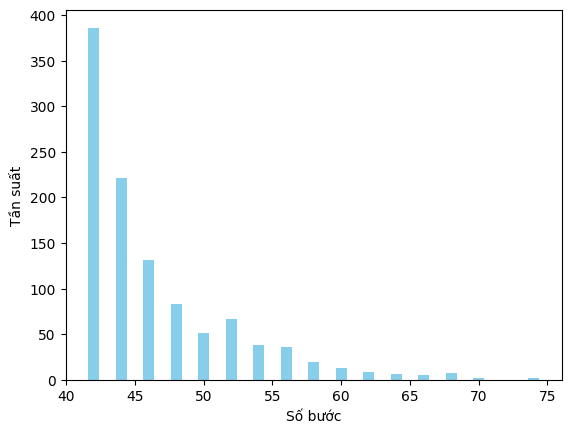

In [50]:
# Hiện biểu đồ thống kê
import matplotlib.pyplot as plt
from collections import Counter
done_statistical = Counter(done_statistical)
done_values = list(done_statistical.keys())  # Các giá trị duy nhất
done_frequencies = list(done_statistical.values())

# Vẽ biểu đồ cột
plt.bar(done_values, done_frequencies, color="skyblue")

# Thêm nhãn và tiêu đề
plt.xlabel("Số bước")
plt.ylabel("Tần suất")
plt.title("")

# Hiển thị biểu đồ
plt.show()